In [5]:
import numpy as np
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst import LsstCamMapper as camMapper

# Scan to reconstruct the beam

In [6]:
raft = 'R22'
sensor = 'S11'
reb = 'Reb1'
ccdid = raft + '_' + sensor
camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)
det = lct.getDetector(ccdid)
ref_sensor = det.getSerial()
print(ref_sensor)

E2V-CCD250-382


### Define the center of the scan as the center of Segment 14 of the central CCD
Finding where the center of Segment 14 of the CCD is in focal plane coordinates.
Note that (xcam, ycam) = (yfp, xfp) because of the different conventions

In [7]:
if 'E2V' in ref_sensor:
    ycenter, xcenter = lct.ccdPixelToFocalMm(2304,3003,ccdid) #e2V
else:
    ycenter, xcenter = lct.ccdPixelToFocalMm(2286,3000,ccdid) #ITL

In [8]:
xcenter, ycenter

(10.015, 2.5649999999999977)

### Define the scan parameters: Delta_x, Delta_y, N_x, N_y
From now on, working in camera coordinate system

In [9]:
Delta_x = 80 # mm
Delta_y = 80 # mm
N_x = 60
N_y = 60

In [10]:
xmin = xcenter - Delta_x / 2.
xmax = xcenter + Delta_x / 2.
ymin = ycenter - Delta_y / 2.
ymax = ycenter + Delta_y / 2.
print(xmin, xmax, ymin, ymax)

-29.985 50.015 -37.435 42.565


In [11]:
xarr = np.linspace(xmin, xmax, N_x)
yarr = np.linspace(ymin, ymax, N_y)
#print(xarr, yarr)

In [12]:
xall = np.repeat(xarr, N_y)
yall = np.broadcast_to(yarr, (N_y, N_x)).flatten()

In [13]:
led = ['uv', 'blue', 'red', 'nm750', 'nm850', 'nm960']
current = [0.1, 0.006, 0.009, 0.01, 0.01, 0.01]
exp_time_orig = [0.02, 0.05, 0.05, 0.09, 0.06, 0.12]
exp_time_corr_factor = [1.33, 1.69, 1.46, 1.4, 1.5, 2.7]
exp_time = np.array(exp_time_orig) * np.array(exp_time_corr_factor)
led_config = list(zip(led, current, np.around(exp_time,2)))
led_config

[('uv', 0.1, 0.03),
 ('blue', 0.006, 0.08),
 ('red', 0.009, 0.07),
 ('nm750', 0.01, 0.13),
 ('nm850', 0.01, 0.09),
 ('nm960', 0.01, 0.32)]

In [14]:
led_number = 5
np.savetxt('tmp.txt', list(zip(xall, yall)),fmt='%.3f', delimiter=('  '))
config_filename = '/home/combet/ccob_'+str(N_x)+'x'+str(N_y)+'_'+raft+'_'+sensor+'_'+led[led_number]+'.cfg'

#config_filename = '/home/combet/bot-eotest-configs/Run4/step22/with_offsets/ccob_'+str(N_x)+'x'+str(N_y)+'_'+raft+'_'+sensor+'_'+led[led_number]+'.cfg'
#config_filename = '/home/combet/bot-eotest-configs/Run4/step22/with_offsets/ccob_'+str(N_x)+'x'+str(N_y)+'_'+raft+'_'+sensor+'_all.cfg'
config_filename

'/home/combet/ccob_60x60_R22_S11_nm960.cfg'

In [15]:
with open('tmp.txt', 'r') as istr:
    with open(config_filename, 'w') as ostr:
        print('[ACQUIRE]', file=ostr)
        print('bias', file=ostr)
        print('ccob', file=ostr)
        print('bias\n', file=ostr)
        print('[BIAS]', file=ostr)
        print('COUNT=10', file=ostr)
        print('LOCATIONS = '+raft+'/'+reb+'\n', file=ostr)
        print('[CCOB]', file=ostr)
        print('BCOUNT = 0', file=ostr)
        print('IMCOUNT = 1', file=ostr)
        print('XOFFSET = 5.0', file=ostr)
        print('YOFFSET = -7.0', file=ostr)
        print('LOCATIONS = '+raft+'/'+reb+'\n', file=ostr)
#        led_number = 0
        print('expose = '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+'\n', file=ostr)
#         led_number = 1
#         print('         '+ str(led_config[led_number][0])+' '
#               + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
#         led_number = 2
#         print('         '+ str(led_config[led_number][0])+' '
#               + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
#         led_number = 3
#         print('         '+ str(led_config[led_number][0])+' '
#               + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
#         led_number = 4
#         print('         '+ str(led_config[led_number][0])+' '
#               + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
#         led_number = 5
#         print('         '+ str(led_config[led_number][0])+' '
#               + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+'\n', file=ostr)
        for i,line in enumerate(istr):
            if i==0: 
                line = 'point =  ' + line.rstrip('\n') + ','
            elif i!=len(xall)-1:
                line = '         ' + line.rstrip('\n') + ','
            else:
                line = '         ' + line.rstrip('\n')
            print(line, file=ostr)

# Scan to get the QE data

In [165]:
camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)
raft_list = ['R01','R02','R03',
             'R10','R11','R12','R13','R14',
             'R20','R21','R22','R23','R24',
             'R30','R31','R32','R33','R34',
             'R41','R42','R43']
sensor_list = ['S00','S01','S02','S10','S11','S12','S20','S21','S22']
fp_pos_e2v = [(1024,3003),(3072,3003),(2048,2002),(1024,1001),(3072,1001)] 
fp_pos_itl = [(1018,3000),(3054,3000),(2036,2000),(1018,1000),(3054,1000)] 

xall=np.zeros((len(raft_list),len(sensor_list)*len(fp_pos_e2v)))
yall=np.zeros((len(raft_list),len(sensor_list)*len(fp_pos_e2v)))

for i,raft in enumerate(raft_list):
    for j,sensor in enumerate(sensor_list):
        ccdid = raft + '_' + sensor
        det = lct.getDetector(ccdid)
        fp_pos = fp_pos_e2v
        if 'ITL' in det.getSerial(): fp_pos = fp_pos_itl
        for k,pos in enumerate(fp_pos):
            ycenter, xcenter = lct.ccdPixelToFocalMm(pos[0],pos[1],ccdid)
            l = j*len(fp_pos)+k
            xall[i][l] = xcenter
            yall[i][l] = ycenter

In [166]:
xall[0]
#list(zip(xall[0],yall[0]))

array([-285.985, -285.985, -295.985, -305.985, -305.985, -286.115,
       -286.115, -296.115, -306.115, -306.115, -286.165, -286.165,
       -296.165, -306.165, -306.165, -243.715, -243.715, -253.715,
       -263.715, -263.715, -243.795, -243.795, -253.795, -263.795,
       -263.795, -243.895, -243.895, -253.895, -263.895, -263.895,
       -201.435, -201.435, -211.435, -221.435, -221.435, -201.515,
       -201.515, -211.515, -221.515, -221.515, -201.595, -201.595,
       -211.595, -221.595, -221.595])

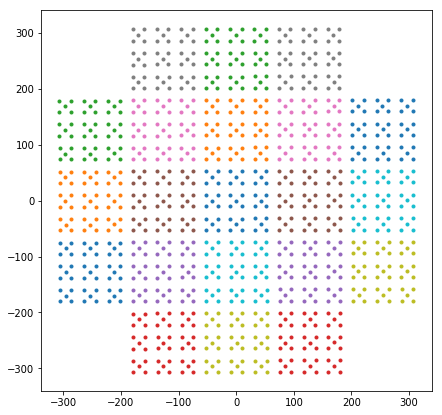

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,7))
for i in np.arange(len(xall)):
    plt.scatter(xall[i], yall[i], marker='.')

In [168]:
for ii,raft in enumerate(raft_list):
    np.savetxt('tmp.txt', list(zip(xall[ii], yall[ii])),fmt='%.3f', delimiter=('  '))
    config_filename = '/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_'+raft+'_all.cfg'
    print(config_filename)
    with open('tmp.txt', 'r') as istr:
        with open(config_filename, 'w') as ostr:
            print('[ACQUIRE]', file=ostr)
            print('bias', file=ostr)
            print('ccob', file=ostr)
            print('bias\n', file=ostr)
            print('[BIAS]', file=ostr)
            print('COUNT=10', file=ostr)
#            print('LOCATIONS = '+raft+'/'+reb+'\n', file=ostr)
            print('LOCATIONS = '+raft+'\n', file=ostr)
            print('[CCOB]', file=ostr)
            print('BCOUNT = 0', file=ostr)
            print('IMCOUNT = 5', file=ostr)
            print('XOFFSET = 5.0', file=ostr)
            print('YOFFSET = -7.0', file=ostr)
#            print('LOCATIONS = '+raft+'/'+reb+'\n', file=ostr)
            print('LOCATIONS = '+raft+'\n', file=ostr)
            led_number = 0
            print('expose = '+ str(led_config[led_number][0])+' '
                  + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
            led_number = 1
            print('         '+ str(led_config[led_number][0])+' '
                  + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
            led_number = 2
            print('         '+ str(led_config[led_number][0])+' '
                  + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
            led_number = 3
            print('         '+ str(led_config[led_number][0])+' '
                  + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
            led_number = 4
            print('         '+ str(led_config[led_number][0])+' '
                  + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
            led_number = 5
            print('         '+ str(led_config[led_number][0])+' '
                  + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+'\n', file=ostr)
            for i,line in enumerate(istr):
                if i==0: 
                    line = 'point =  ' + line.rstrip('\n') + ','
                elif i!=len(xall[ii])-1:
                    line = '         ' + line.rstrip('\n') + ','
                else:
                    line = '         ' + line.rstrip('\n')
                print(line, file=ostr)

/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R01_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R02_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R03_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R10_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R11_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R12_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R13_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R14_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R20_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R21_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R22_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R23_all.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R24_all.cfg

In [169]:
for ii,raft in enumerate(raft_list):
    np.savetxt('tmp.txt', list(zip(xall[ii], yall[ii])),fmt='%.3f', delimiter=('  '))
    config_filename = '/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_'+raft+'_all_byREB.cfg'
    print(config_filename)
    with open(config_filename, 'w') as ostr:
        print('[ACQUIRE]', file=ostr)
        print('BIAS1', file=ostr)
        print('CCOB1', file=ostr)
        print('BIAS2', file=ostr)
        print('CCOB2', file=ostr)
        print('BIAS3', file=ostr)
        print('CCOB3\n', file=ostr)


        print('[BIAS1]', file=ostr)
        print('COUNT=10', file=ostr)
        print('LOCATIONS = '+raft+'/Reb0 \n', file=ostr)
        print('[BIAS2]', file=ostr)
        print('COUNT=10', file=ostr)
        print('LOCATIONS = '+raft+'/Reb1 \n', file=ostr)
        print('[BIAS3]', file=ostr)
        print('COUNT=10', file=ostr)
        print('LOCATIONS = '+raft+'/Reb2 \n', file=ostr)

        print('[CCOB1]', file=ostr)
        print('BCOUNT = 0', file=ostr)
        print('IMCOUNT = 5', file=ostr)
        print('XOFFSET = 5.0', file=ostr)
        print('YOFFSET = -7.0', file=ostr)
        print('LOCATIONS = '+raft+'/Reb0 \n', file=ostr)
        led_number = 0
        print('expose = '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 1
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 2
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 3
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 4
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 5
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+'\n', file=ostr)
        with open('tmp.txt', 'r') as istr:
            for i,line in enumerate(list(istr)[0:15]):
                if i==0: 
                    line = 'point =  ' + line.rstrip('\n') + ','
                elif i!=14:
                    line = '         ' + line.rstrip('\n') + ','
                else:
                    line = '         ' + line.rstrip('\n\n')
                print(line, file=ostr)
                
        print('\n[CCOB2]', file=ostr)
        print('BCOUNT = 0', file=ostr)
        print('IMCOUNT = 5', file=ostr)
        print('XOFFSET = 5.0', file=ostr)
        print('YOFFSET = -7.0', file=ostr)
        print('LOCATIONS = '+raft+'/Reb1 \n', file=ostr)
        led_number = 0
        print('expose = '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 1
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 2
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 3
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 4
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 5
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+'\n', file=ostr)

        with open('tmp.txt', 'r') as istr:
            for i,line in enumerate(list(istr)[15:30]):
                if i==0: 
                    line = 'point =  ' + line.rstrip('\n') + ','
                elif i!=14:
                    line = '         ' + line.rstrip('\n') + ','
                else:
                    line = '         ' + line.rstrip('\n')
                print(line, file=ostr)
              
        print('\n[CCOB3]', file=ostr)
        print('BCOUNT = 0', file=ostr)
        print('IMCOUNT = 5', file=ostr)
        print('XOFFSET = 5.0', file=ostr)
        print('YOFFSET = -7.0', file=ostr)
        print('LOCATIONS = '+raft+'/Reb2 \n', file=ostr)
        led_number = 0
        print('expose = '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 1
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 2
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 3
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 4
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+',', file=ostr)
        led_number = 5
        print('         '+ str(led_config[led_number][0])+' '
              + str(led_config[led_number][1])+' '+str(led_config[led_number][2])+'\n', file=ostr)

        with open('tmp.txt', 'r') as istr:
            for i,line in enumerate(list(istr)[30:45]):
                if i==0: 
                    line = 'point =  ' + line.rstrip('\n') + ','
                elif i!=14:
                    line = '         ' + line.rstrip('\n') + ','
                else:
                    line = '         ' + line.rstrip('\n')
                print(line, file=ostr)

/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R01_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R02_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R03_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R10_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R11_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R12_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R13_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R14_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R20_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R21_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R22_all_byREB.cfg
/home/combet/bot-eotest-configs/Run4/step23/with_offsets/ccob_qe_R23_all_byREB.cfg
/hom

In [106]:
with open('tmp.txt', 'r') as istr:
    for i,line in enumerate(list(istr)):
        print(line)

221.715  75.055

221.715  95.415

211.715  85.235

201.715  75.055

201.715  95.415

221.585  117.335

221.585  137.695

211.585  127.515

201.585  117.335

201.585  137.695

221.535  159.605

221.535  179.965

211.535  169.785

201.535  159.605

201.535  179.965

263.985  75.105

263.985  95.465

253.985  85.285

243.985  75.105

243.985  95.465

263.905  117.425

263.905  137.785

253.905  127.605

243.905  117.425

243.905  137.785

263.805  159.705

263.805  180.065

253.805  169.885

243.805  159.705

243.805  180.065

306.265  75.235

306.265  95.595

296.265  85.415

286.265  75.235

286.265  95.595

306.185  117.525

306.185  137.885

296.185  127.705

286.185  117.525

286.185  137.885

306.105  159.785

306.105  180.145

296.105  169.965

286.105  159.785

286.105  180.145



In [13]:
lct.focalMmToCcdPixel(-1.071,-0.894)

('R22_S11', 1940.4000000000003, 1912.1)

In [36]:
lct.focalMmToCcdPixel(7.5, 2.9)

('R22_S11', 2797.5, 2291.5)

In [37]:
lct.focalMmToCcdPixel(2.5649999999999977,10.015)

('R22_S11', 2304.0, 3003.0)

In [11]:
import sys
sys.path.insert(0, '../')
import ccob_QE_data as qe_data
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
ccdid = 'R30_S11'
led = 'red'
path_to_data = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/'
gainfile='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6801D/fe55_analysis_BOT/v0/47706/R30_S11_6801D_eotest_results.fits'
data = qe_data.CcobQeData(ccdid, led, path_to_data, gainfile, None)

In [77]:
data

In [78]:
data.find_dir()
data.dir_list

array(['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_red_117.595_-243.655_735',
       '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_red_117.595_-243.655_736',
       '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_red_117.595_-243.655_737',
       '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_red_117.595_-243.655_738',
       '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_red_117.595_-243.655_739',
       '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_red_117.595_-264.135_705',
       '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_sta

In [79]:
data.pos_list

array(['117.595_-243.655', '117.595_-264.135', '127.605_-253.895',
       '137.615_-243.655', '137.615_-264.135'], dtype='<U16')

In [94]:
data.make_avg_mosaic_at_pos(data.pos_list[2], '/home/combet/tmp_9rafts/')

(array([[ 5888.68408203, 15768.27636719, 20690.328125  , ...,
         21671.15429688, 17100.51953125,  7844.8125    ],
        [ 8151.953125  , 19516.0859375 , 24660.52539062, ...,
         25588.42382812, 20869.02148438,  9760.5703125 ],
        [10755.06445312, 23848.59960938, 30082.49023438, ...,
         30159.47265625, 23831.078125  , 11537.0546875 ],
        ...,
        [10589.49121094, 23188.85742188, 29385.94726562, ...,
         26425.34179688, 21162.16992188,  9844.43261719],
        [ 8572.70019531, 19682.73632812, 25211.2421875 , ...,
         22868.37695312, 17817.44921875,  7837.51806641],
        [ 7390.65869141, 17988.88085938, 22582.51953125, ...,
         20508.2421875 , 15538.59863281,  6161.52783203]]),
 {(0, 0): {'amp': 1,
   'segment': 'SEGMENT10',
   'xmin': 3584,
   'xmax': 4096,
   'ymin': 2002,
   'ymax': 4004,
   'flipx': False,
   'flipy': True,
   'detsec': {'xmin': 512, 'xmax': 1, 'ymin': 1, 'ymax': 2002},
   'datasec': {'xmin': 11, 'xmax': 522, 'ymin': 

In [84]:
data.data

{'117.595_-243.655': {'mosaic': array([[ 5960.43896484, 16083.70898438, 21079.1015625 , ...,
          20159.65625   , 15813.31835938,  7191.59570312],
         [ 8326.41699219, 19789.9140625 , 24904.78125   , ...,
          23780.48046875, 19267.06445312,  9022.61816406],
         [10896.18261719, 24134.03320312, 30425.88476562, ...,
          27850.51367188, 22195.01171875, 10690.60742188],
         ...,
         [ 9937.85351562, 21685.34960938, 27340.65625   , ...,
          21515.91601562, 17255.25390625,  7992.20654297],
         [ 8000.60058594, 18454.73242188, 23394.18945312, ...,
          18624.14453125, 14567.82128906,  6411.14746094],
         [ 6839.06298828, 16870.140625  , 21135.25195312, ...,
          16714.46289062, 12690.88085938,  5002.72119141]]),
  'amp_coord': {(0, 0): {'amp': 1,
    'segment': 'SEGMENT10',
    'xmin': 3584,
    'xmax': 4096,
    'ymin': 2002,
    'ymax': 4004,
    'flipx': False,
    'flipy': True,
    'detsec': {'xmin': 512, 'xmax': 1, 'ymin': 1

In [85]:
import matplotlib.pyplot as plt

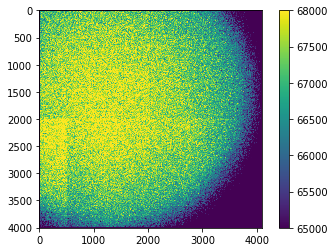

In [95]:
plt.imshow(data.data[data.pos_list[2]]['mosaic'], vmin=65000, vmax=68000)
plt.colorbar()